In [15]:
#import all libraries
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocessing
1- Reading

2- Smoothing

In [ ]:
datasets = {}  # Initialize a dictionary to store datasets

# Iterate over activity names
activity_names = ["Abduction", "Elbow Extension", "Elbow Flexion", "External Rotation", "Internal Rotation", "Shoulder Extension", "Shoulder Flexion"]

for activity in activity_names:
    dfs = []  # Initialize a list to store DataFrames for each activity

    for i in range(1,11):
            df = pd.read_csv(f'/content/drive/MyDrive/PASCIR Dataset/{activity}_ID{i}.csv')
            dfs.append(df)

    # Concatenate DataFrames for each activity
    datasets[activity] = pd.concat(dfs, ignore_index=True)
    if 'yyyy/mm/dd hh:mm:ss.000' in datasets[activity].columns:
      datasets[activity] = datasets[activity].drop(columns='yyyy/mm/dd hh:mm:ss.000')

    if 'hh:mm:ss.000' in datasets[activity].columns:
      datasets[activity] = datasets[activity].drop(columns='hh:mm:ss.000')

# Access each dataset by activity name
abduction_dataset = datasets['Abduction']
elbow_extension_dataset = datasets['Elbow Extension']
elbow_flexion_dataset = datasets['Elbow Flexion']
external_rotation_dataset = datasets['External Rotation']
internal_rotation_dataset = datasets['Internal Rotation']
shoulder_extension_dataset = datasets['Shoulder Extension']
shoulder_flexion_dataset = datasets['Shoulder Flexion']

In [ ]:
# Concatenate the dataframes along the rows (axis=0)
pre_combined_dataframe = pd.concat(datasets, axis=0, ignore_index=True)

In [ ]:
pre_combined_dataframe

,X,Y,Z,Activity
0,-3.600132,-8.780723,-0.312846,Abduction
1,-3.589581,-8.787952,-0.281064,Abduction
2,-3.600934,-8.797590,-0.232737,Abduction
3,-3.615687,-8.837349,-0.170439,Abduction
4,-3.636997,-8.854217,-0.104616,Abduction
...,...,...,...,...
52261,-4.205159,-9.760241,0.407226,Sh Flexion
52262,-3.779635,-9.689157,0.354828,Sh Flexion
52263,-3.249704,-9.648193,0.187828,Sh Flexion
52264,-2.960981,-9.586747,0.011139,Sh Flexion


In [ ]:
def smoothing (dataset):
  # Data smoothing using Exponential Moving Average filter
  dataset['X'] = dataset['X'].ewm(span=10).mean()
  dataset['Y'] = dataset['Y'].ewm(span=10).mean()
  dataset['Z'] = dataset['Z'].ewm(span=10).mean()

In [ ]:
# smoothing(pre_combined_dataframe) # this will be runed on new data

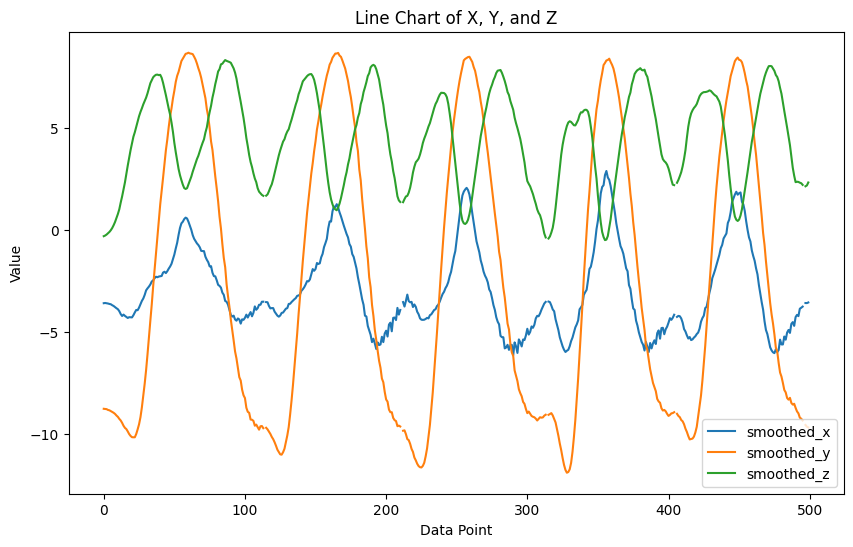

In [ ]:
#ploting for the data after using Exponential Moving avrage filter
subset = pre_combined_dataframe.iloc[:500]
smoothed_x = subset['X']
smoothed_y = subset['Y']
smoothed_z = subset['Z']
plt.figure(figsize=(10, 6))

#Create a line chart
plt.plot(smoothed_x, label='smoothed_x')
plt.plot(smoothed_y, label='smoothed_y')
plt.plot(smoothed_z, label='smoothed_z')

#Add labels and title
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title('Line Chart of X, Y, and Z')
plt.legend()

#Feature Extraction

In [17]:
def magnitude(series):
    return ((series ** 2).sum())**0.5

def calculate_std_dev(x):
    return x.std()

def calculate_range(x):
    return x.max() - x.min()

def calculate_rms(x):
    return np.sqrt(np.mean(x**2))

In [24]:
for i in datasets:
  # Mean
  segments = datasets[i].isnull().all(axis=1).cumsum()
  mean_values = datasets[i].groupby(segments).transform('mean')
  datasets[i][['Mean_X', 'Mean_Y', 'Mean_Z']] = mean_values[['X', 'Y', 'Z']]

  # Max
  segments = datasets[i]['X'].isnull().cumsum()
  max_values = datasets[i].groupby(segments).transform('max')
  datasets[i][['Max_X', 'Max_Y', 'Max_Z']] = max_values[['X', 'Y', 'Z']]

  # Min
  segments = datasets[i]['X'].isnull().cumsum()
  min_values = datasets[i].groupby(segments).transform('min')
  datasets[i][['Min_X', 'Min_Y', 'Min_Z']] = min_values[['X', 'Y', 'Z']]

  # Magnitude
  segments = datasets[i]['X'].isnull().cumsum()
  magnitude_values = datasets[i].groupby(segments).transform(magnitude)
  datasets[i]['M'] = magnitude_values[['X', 'Y', 'Z']].apply(magnitude, axis=1)

  # Std_Dev
  segments = datasets[i]['X'].isnull().cumsum()
  std_dev_values = datasets[i].groupby(segments).transform(calculate_std_dev)
  datasets[i][['Std_Dev_X', 'Std_Dev_Y', 'Std_Dev_Z']] = std_dev_values[['X', 'Y', 'Z']]


  # Range
  segments = datasets[i]['X'].isnull().cumsum()
  range_values = datasets[i].groupby(segments).transform(calculate_range)
  datasets[i][['Range_X', 'Range_Y', 'Range_Z']] = range_values[['X', 'Y', 'Z']]

  # RMS
  segments = datasets[i]['X'].isnull().cumsum()
  rms_values = datasets[i].groupby(segments).transform(calculate_rms)
  datasets[i][['RMS_X', 'RMS_Y', 'RMS_Z']] = rms_values[['X', 'Y', 'Z']]

<ipython-input-24-10b77a7e6d18>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_values = datasets[i].groupby(segments).transform('mean')
<ipython-input-24-10b77a7e6d18>:9: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  max_values = datasets[i].groupby(segments).transform('max')
<ipython-input-24-10b77a7e6d18>:14: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  min_values = datasets[i].groupby(segments).transform('min')
<ipython-input-24-10b77a7e6d18>:19: FutureWarning: 

In [22]:
# Concatenate the dataframes along the rows (axis=0)
combined_dataframe = pd.concat(datasets, axis=0, ignore_index=True)

In [ ]:
# combined_dataframe[combined_dataframe['Activity']==' Sh Extension'] = 'Sh Extension'
# combined_dataframe[combined_dataframe['Activity']=='Flexor'] = 'Sh Flexion'

# # Assuming 'Activity' is the column for which you want to print unique values
# unique_activities = combined_dataframe['Activity'].unique()
# # Print the unique values
# print("Unique Activities:")
# for activity in unique_activities:
#     print(activity)

In [23]:
combined_dataframe

,X,Y,Z,Activity,Mean_X,Mean_Y,Mean_Z,Max_X,Max_Y,Max_Z,...,M,Std_Dev_X,Std_Dev_Y,Std_Dev_Z,Range_X,Range_Y,Range_Z,RMS_X,RMS_Y,RMS_Z
0,-3.600132,-8.780723,-0.312846,Abduction,-1.58494,-2.587967,4.408253,0.598435,8.687952,8.327481,...,9.495258,1.480863,7.073688,2.539044,5.200332,18.866265,8.640327,3.120314,7.406772,5.213927
1,-3.589581,-8.787952,-0.281064,Abduction,-1.58494,-2.587967,4.408253,0.598435,8.687952,8.327481,...,9.496957,1.480863,7.073688,2.539044,5.200332,18.866265,8.640327,3.120314,7.406772,5.213927
2,-3.600934,-8.797590,-0.232737,Abduction,-1.58494,-2.587967,4.408253,0.598435,8.687952,8.327481,...,9.508863,1.480863,7.073688,2.539044,5.200332,18.866265,8.640327,3.120314,7.406772,5.213927
3,-3.615687,-8.837349,-0.170439,Abduction,-1.58494,-2.587967,4.408253,0.598435,8.687952,8.327481,...,9.549921,1.480863,7.073688,2.539044,5.200332,18.866265,8.640327,3.120314,7.406772,5.213927
4,-3.636997,-8.854217,-0.104616,Abduction,-1.58494,-2.587967,4.408253,0.598435,8.687952,8.327481,...,9.572662,1.480863,7.073688,2.539044,5.200332,18.866265,8.640327,3.120314,7.406772,5.213927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52261,-4.205159,-9.760241,0.407226,Sh Flexion,-4.15726,-2.825807,1.261511,3.176040,9.104819,3.094013,...,10.635389,3.860605,7.903437,0.750461,13.178024,22.081928,3.329862,5.707527,8.465299,1.576210
52262,-3.779635,-9.689157,0.354828,Sh Flexion,-4.15726,-2.825807,1.261511,3.176040,9.104819,3.094013,...,10.406311,3.860605,7.903437,0.750461,13.178024,22.081928,3.329862,5.707527,8.465299,1.576210
52263,-3.249704,-9.648193,0.187828,Sh Flexion,-4.15726,-2.825807,1.261511,3.176040,9.104819,3.094013,...,10.182509,3.860605,7.903437,0.750461,13.178024,22.081928,3.329862,5.707527,8.465299,1.576210
52264,-2.960981,-9.586747,0.011139,Sh Flexion,-4.15726,-2.825807,1.261511,3.176040,9.104819,3.094013,...,10.033606,3.860605,7.903437,0.750461,13.178024,22.081928,3.329862,5.707527,8.465299,1.576210


#Feature Selection

In [34]:
# Drop rows with null values
combined_dataframe_cleaned = combined_dataframe.dropna()
combined_dataframe_noXYZ = combined_dataframe_cleaned.drop(['X', 'Y', 'Z'], axis=1)

# Separate the features (X) and target variable (y) from the cleaned dataframe
X_cleaned = combined_dataframe_cleaned.drop('Activity', axis=1)
y_cleaned = combined_dataframe_cleaned['Activity']

# Separate the features (X) and target variable (y) from the cleaned dataframe
X_cleaned_noXYZ = combined_dataframe_noXYZ.drop('Activity', axis=1)
y_cleaned_noXYZ = combined_dataframe_noXYZ['Activity']

# Apply a simple transformation to make values non-negative
X_transformed = X_cleaned_noXYZ + X_cleaned_noXYZ.min().abs() + 1

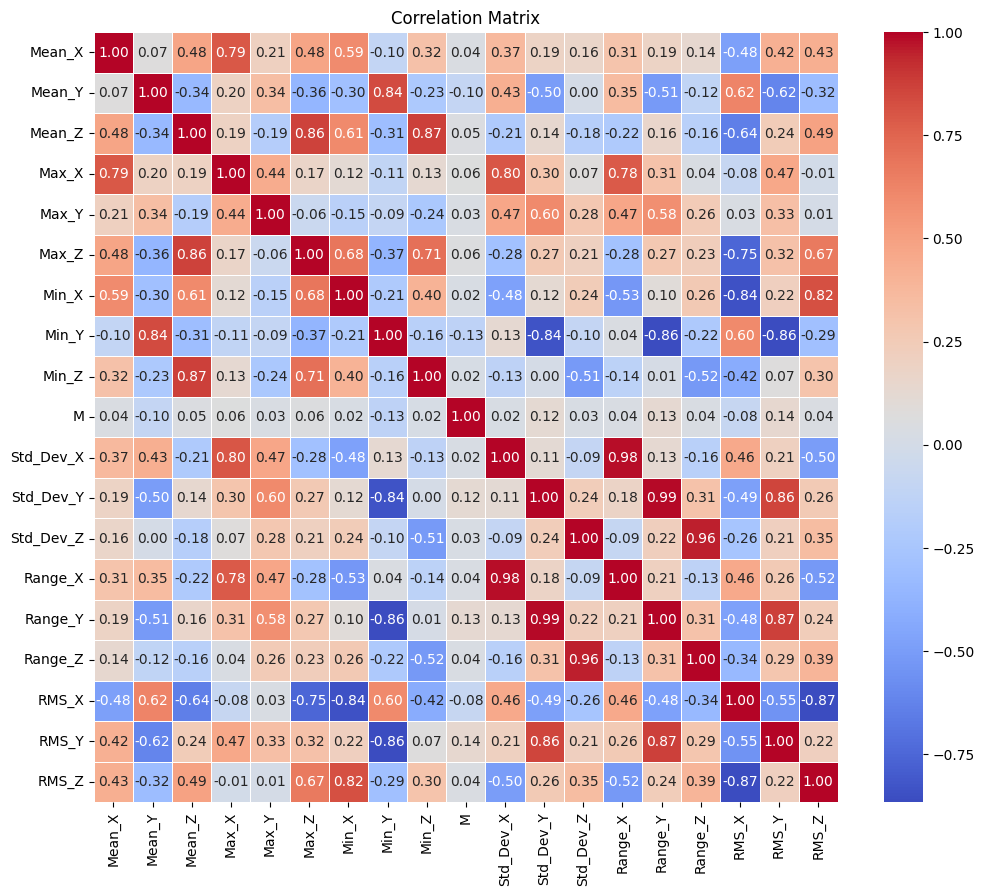

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X_cleaned is your feature matrix
# You may want to include only relevant features in X_cleaned if needed
# X_cleaned = combined_dataframe_cleaned.drop('Activity', axis=1)

# Calculate the correlation matrix
correlation_matrix = X_cleaned_noXYZ.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Plot the correlation matrix using seaborn's heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Show the plot
plt.title('Correlation Matrix')
plt.show()

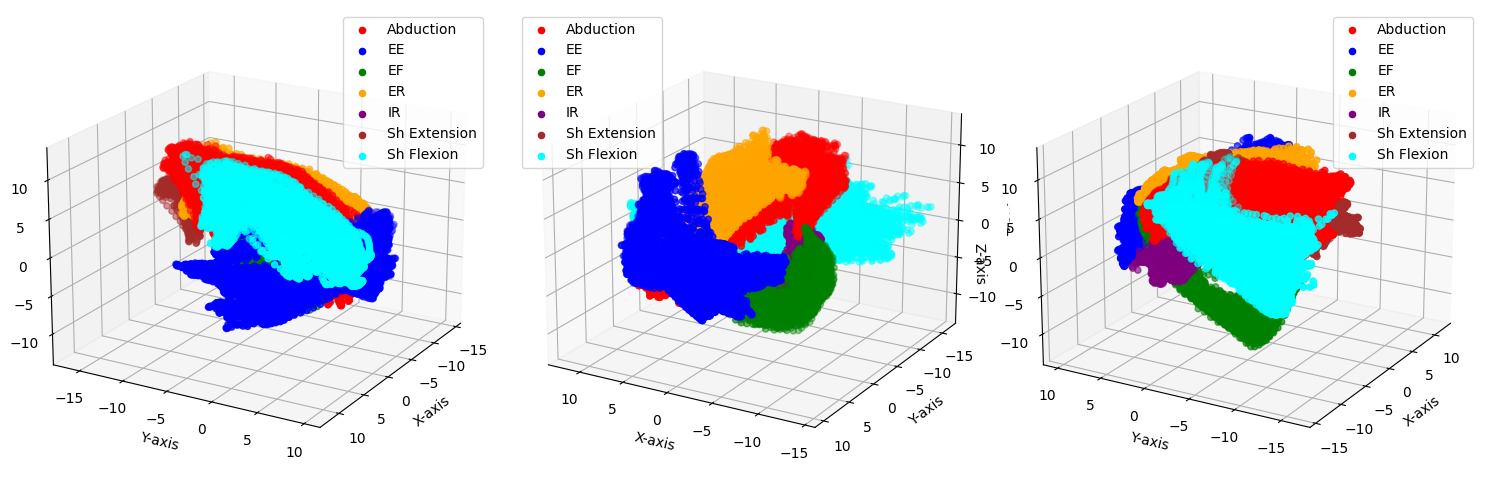

In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming X, Y, Z are the features you want to plot
# Also, assuming 'Activity' is a column in your dataframe indicating the activity for each data point

activity_colors = {
    'Abduction': 'red',
    'EE': 'blue',
    'EF': 'green',
    'ER': 'orange',
    'IR': 'purple',
    'Sh Extension': 'brown',
    'Sh Flexion': 'cyan'
}

# Example data
X = combined_dataframe_cleaned['X']
Y = combined_dataframe_cleaned['Y']
Z = combined_dataframe_cleaned['Z']
activity_labels = combined_dataframe_cleaned['Activity']

# Create three 3D scatter plots from different angles
fig = plt.figure(figsize=(15, 5))

# Plot 1
ax1 = fig.add_subplot(131, projection='3d')
ax1.view_init(elev=20, azim=30)  # Set the view angle
for activity, color in activity_colors.items():
    indices = (activity_labels == activity) & pd.to_numeric(X, errors='coerce').notnull() & pd.to_numeric(Y, errors='coerce').notnull() & pd.to_numeric(Z, errors='coerce').notnull()
    ax1.scatter(pd.to_numeric(X[indices]), pd.to_numeric(Y[indices]), pd.to_numeric(Z[indices]), label=activity, c=color, s=20)
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Y-axis')
ax1.set_zlabel('Z-axis')
ax1.legend()

# Plot 2
ax2 = fig.add_subplot(132, projection='3d')
ax2.view_init(elev=20, azim=120)
for activity, color in activity_colors.items():
    indices = (activity_labels == activity) & pd.to_numeric(X, errors='coerce').notnull() & pd.to_numeric(Y, errors='coerce').notnull() & pd.to_numeric(Z, errors='coerce').notnull()
    ax2.scatter(pd.to_numeric(X[indices]), pd.to_numeric(Y[indices]), pd.to_numeric(Z[indices]), label=activity, c=color, s=20)
ax2.set_xlabel('X-axis')
ax2.set_ylabel('Y-axis')
ax2.set_zlabel('Z-axis')
ax2.legend()

# Plot 3
ax3 = fig.add_subplot(133, projection='3d')
ax3.view_init(elev=20, azim=210)
for activity, color in activity_colors.items():
    indices = (activity_labels == activity) & pd.to_numeric(X, errors='coerce').notnull() & pd.to_numeric(Y, errors='coerce').notnull() & pd.to_numeric(Z, errors='coerce').notnull()
    ax3.scatter(pd.to_numeric(X[indices]), pd.to_numeric(Y[indices]), pd.to_numeric(Z[indices]), label=activity, c=color, s=20)
ax3.set_xlabel('X-axis')
ax3.set_ylabel('Y-axis')
ax3.set_zlabel('Z-axis')
ax3.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [37]:
#1
# K-best selection using mutual_info_classif

from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Initialize SelectKBest with the mutual_info_classif test
k_best_selector_mutual_info = SelectKBest(mutual_info_classif, k=3)

# Fit and transform the feature matrix
X_k_best_mutual_info = k_best_selector_mutual_info.fit_transform(X_transformed, y_cleaned_noXYZ)

# Get the mutual information scores of each feature
feature_scores_mutual_info = k_best_selector_mutual_info.scores_

# Get the indices of the selected features
selected_feature_indices_mutual_info = k_best_selector_mutual_info.get_support(indices=True)

# Display the dataframe with selected features
selected_features_df_mutual_info = X_cleaned_noXYZ.iloc[:, selected_feature_indices_mutual_info]


Feature Scores:
      Feature     Score
15    Range_Z  2.043959
8       Min_Z  2.043873
17      RMS_Y  2.043842
12  Std_Dev_Z  2.043642
6       Min_X  2.043511
16      RMS_X  2.043454
18      RMS_Z  2.043437
5       Max_Z  2.043405
13    Range_X  2.043403
10  Std_Dev_X  2.043329
11  Std_Dev_Y  2.043309
3       Max_X  2.043227
14    Range_Y  2.040322
7       Min_Y  2.023177
4       Max_Y  1.966131
0      Mean_X  1.943374
2      Mean_Z  1.942378
1      Mean_Y  1.941776
9           M  0.309526


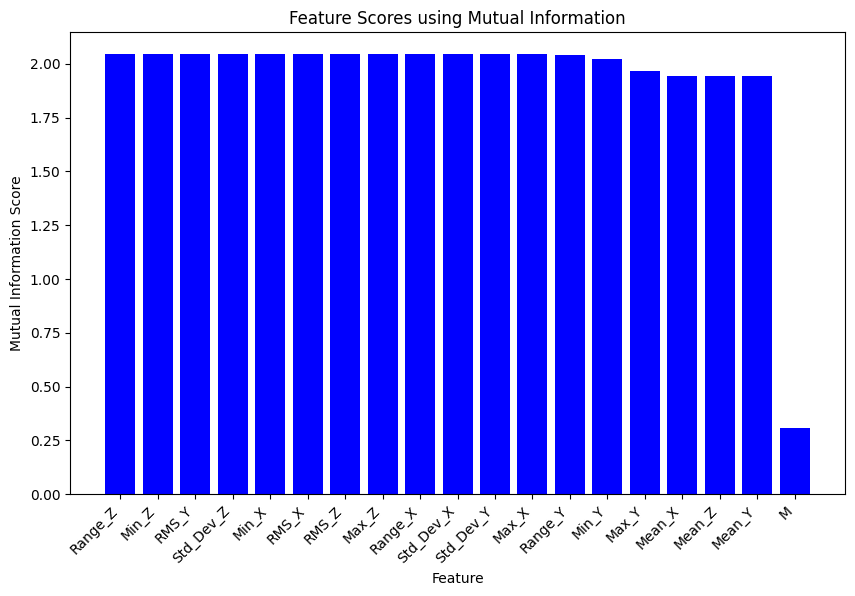

In [39]:
# Create a DataFrame to store feature scores
feature_scores_df = pd.DataFrame({'Feature': X_cleaned_noXYZ.columns, 'Score': feature_scores_mutual_info})

# Sort the DataFrame by score in descending order
feature_scores_df = feature_scores_df.sort_values(by='Score', ascending=False)

# Display the DataFrame
print("\nFeature Scores:")
print(feature_scores_df)

# Plot each feature with its score
plt.figure(figsize=(10, 6))
plt.bar(feature_scores_df['Feature'], feature_scores_df['Score'], color='blue')
plt.xlabel('Feature')
plt.ylabel('Mutual Information Score')
plt.title('Feature Scores using Mutual Information')
plt.xticks(rotation=45, ha='right')
plt.show()

In [40]:
# 2
#VarianceThreshold selection

from sklearn.feature_selection import VarianceThreshold
import pandas as pd

# Initialize VarianceThreshold with a threshold value
threshold_value = 0.1
variance_selector = VarianceThreshold(threshold=threshold_value)

# Fit the selector to your data
variance_selector.fit(X_transformed)

# Get the indices of the features that are retained
selected_features_indices = variance_selector.get_support(indices=True)

# Transform the original data to keep only the selected features
selected_data = variance_selector.transform(X_transformed)

# Create a new DataFrame with the selected features
selected_features_df = X_transformed.iloc[:, selected_features_indices]


Feature Variances:
      Feature   Variance
14    Range_Y  34.986013
13    Range_X  31.312074
7       Min_Y  23.329667
3       Max_X  22.882615
8       Min_Z  16.700526
2      Mean_Z  12.977054
5       Max_Z  12.815006
6       Min_X  12.314529
0      Mean_X  10.244445
4       Max_Y   8.921667
1      Mean_Y   8.823583
15    Range_Z   8.822149
16      RMS_X   6.900447
11  Std_Dev_Y   4.969635
9           M   4.647290
18      RMS_Z   4.344017
17      RMS_Y   4.303726
10  Std_Dev_X   3.784200
12  Std_Dev_Z   0.890281


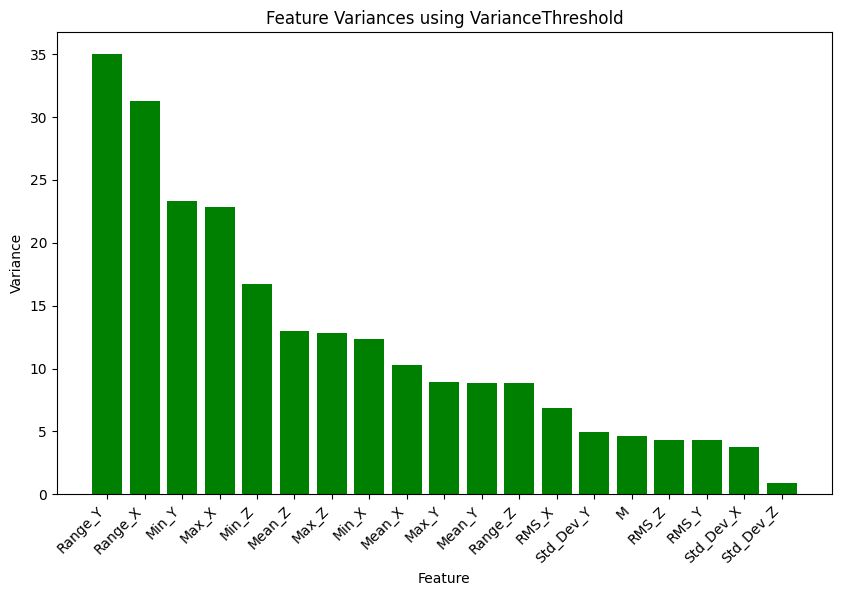

In [41]:
# Get the variance scores of each feature
feature_variances = variance_selector.variances_

# Create a DataFrame to store feature variances
variance_df = pd.DataFrame({'Feature': X_transformed.columns, 'Variance': feature_variances})

# Sort the DataFrame by variance in descending order
variance_df = variance_df.sort_values(by='Variance', ascending=False)

# Display the DataFrame
print("\nFeature Variances:")
print(variance_df)

# Plot each feature with its variance
plt.figure(figsize=(10, 6))
plt.bar(variance_df['Feature'], variance_df['Variance'], color='green')
plt.xlabel('Feature')
plt.ylabel('Variance')
plt.title('Feature Variances using VarianceThreshold')
plt.xticks(rotation=45, ha='right')
plt.show()

In [46]:
#3
#Principal Component Analysis Selection

from sklearn.decomposition import PCA
import pandas as pd

# Initialize PCA with the desired number of components
n_components = 5
pca = PCA(n_components=n_components)

# Fit and transform the data using PCA
X_pca = pca.fit_transform(X_transformed)

# Create a new DataFrame with the selected principal components
selected_features_df = pd.DataFrame(data=X_pca, columns=[f'PC{i}' for i in range(1, n_components + 1)])

# Access the feature importance from the PCA model
feature_importance = pd.DataFrame(pca.components_.T, columns=[f'PC{i}' for i in range(1, n_components + 1)], index=X_cleaned_noXYZ.columns)

<ipython-input-47-34f8f5c1dc75>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(feature_importance_i.index, rotation=45, ha='right')  # Use set_xticklabels for rotation


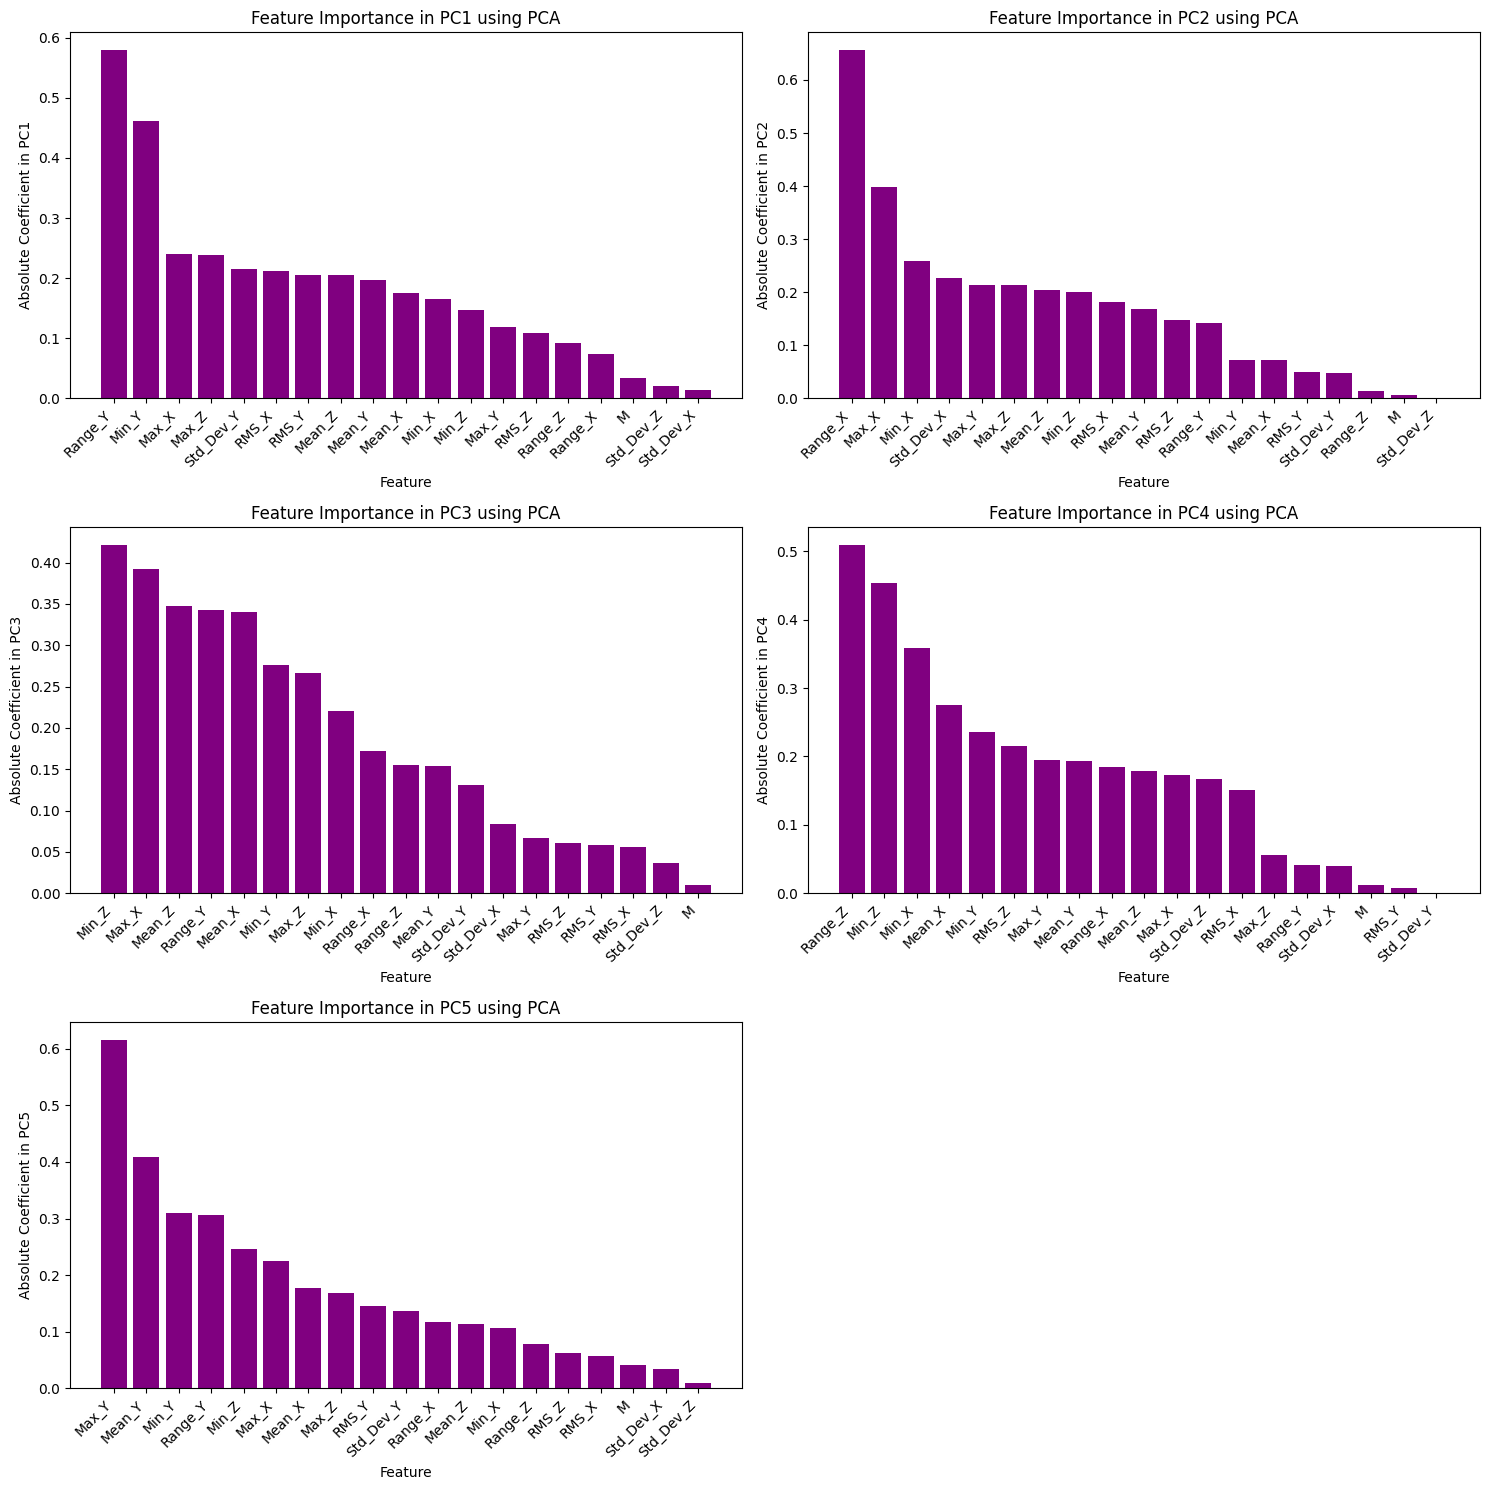

In [47]:
import matplotlib.pyplot as plt

# Set the number of principal components
n_components = 5

# Calculate the number of rows and columns for subplots
n_rows = (n_components + 1) // 2  # Ensure there is at least one row
n_cols = 2

# Create subplots with two plots per row
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array if there is only one row
axes = axes.flatten()

# Loop through each principal component
for i in range(n_components):
    feature_importance_i = feature_importance[f'PC{i + 1}'].abs().sort_values(ascending=False)
    axes[i].bar(feature_importance_i.index, feature_importance_i, color='purple')
    axes[i].set_xlabel('Feature')
    axes[i].set_ylabel(f'Absolute Coefficient in PC{i + 1}')
    axes[i].set_title(f'Feature Importance in PC{i + 1} using PCA')
    axes[i].set_xticklabels(feature_importance_i.index, rotation=45, ha='right')  # Use set_xticklabels for rotation

# Hide empty subplots if there are an odd number of principal components
for i in range(n_components, n_rows * n_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


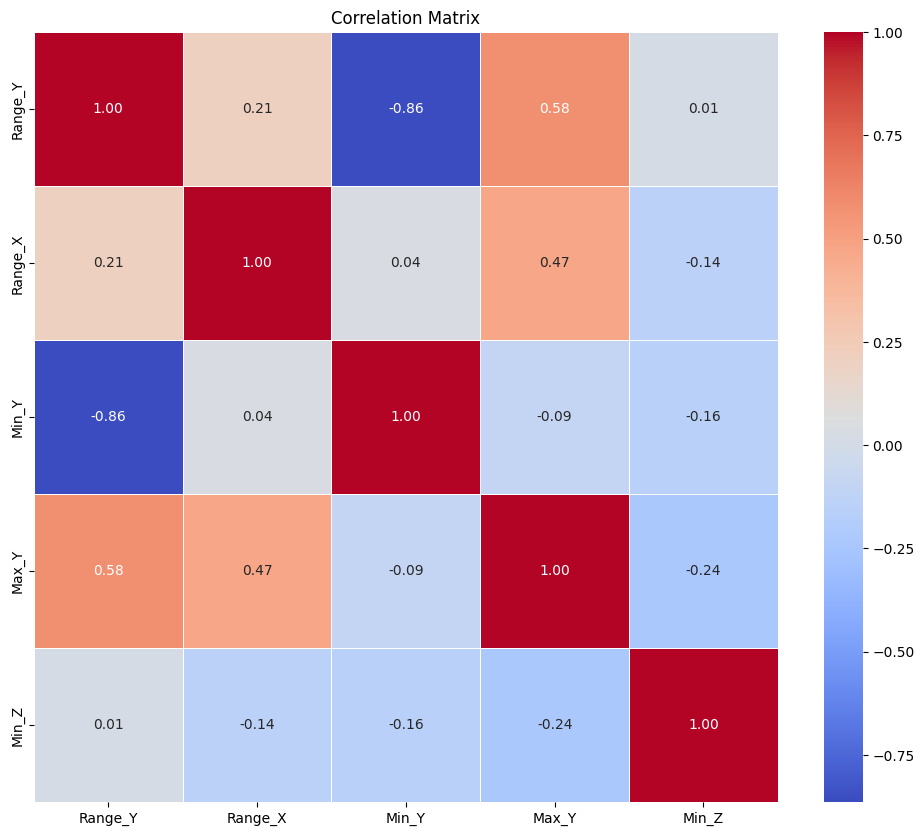

In [49]:
# Assuming df is your DataFrame
columns_of_interest = ['Range_Y', 'Range_X', 'Min_Y','Max_Y', 'Min_Z']

# Extract the specified columns
selected_columns_df = X_cleaned[columns_of_interest]

# Calculate the correlation matrix
correlation_matrix = selected_columns_df.corr()


# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Plot the correlation matrix using seaborn's heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Show the plot
plt.title('Correlation Matrix')
plt.show()

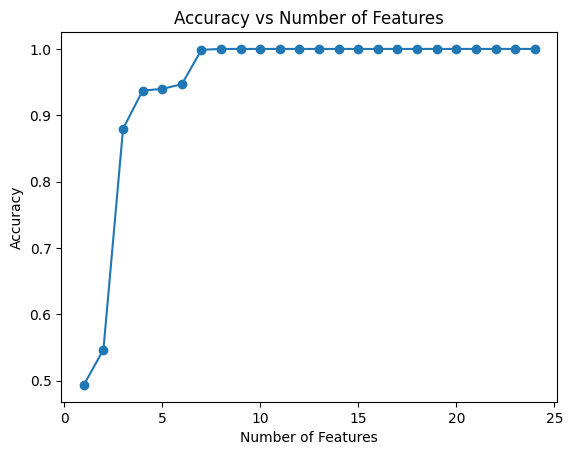

In [ ]:
_Zimport matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, chi2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# Trial to know the best number of parameters
# Function to calculate accuracy with different feature subsets
def plot_accuracy_vs_features(X, y, max_features):
    accuracies = []

    for k in range(1, max_features + 1):
        k_best_selector = SelectKBest(chi2, k=k)
        X_k_best = k_best_selector.fit_transform(X, y)

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_k_best, y, test_size=0.2, random_state=42)

        # Train an SVM classifier
        clf = SVC(kernel='linear', C=1, decision_function_shape='ovr', random_state=42)
        clf.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = clf.predict(X_test)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Plot the results
    plt.plot(range(1, max_features + 1), accuracies, marker='o')
    plt.title('Accuracy vs Number of Features')
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.show()

# Use the cleaned data and transformed features
max_features_to_plot = X_cleaned.shape[1]  # Plot up to the total number of features
plot_accuracy_vs_features(X_transformed, y_cleaned, max_features_to_plot)


# Explore Data (plot method1)

In [ ]:
def plotSegments (df):

  # Identify rows with null values
  null_rows = df[df.isnull().any(axis=1)]

  # Initialize a list to store subsets
  subsets = []

  # Split DataFrame into subsets based on null rows
  start_idx = 0
  for idx in null_rows.index:
      subset = df.iloc[start_idx:idx]
      subsets.append(subset)
      start_idx = idx + 1

  # Add the last subset (if any)
  if start_idx < len(df):
      subsets.append(df.iloc[start_idx:])

  # Define the number of plots per row for visualization
  plots_per_row = 3

  # Calculate the number of rows needed
  num_rows = (len(subsets) + plots_per_row - 1) // plots_per_row

  # Create subplots
  fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, 5 * num_rows))

  # Flatten the axes array for easy iteration
  axes = axes.flatten()

  # Loop through each subset and plot line charts
  for i, subset in enumerate(subsets):
      ax = axes[i]
      #ploting for the data after using Exponential Moving avrage filter
      ax.plot(subset['X'], label='X')
      ax.plot(subset['Y'], label='Y')
      ax.plot(subset['Z'], label='Z')
      ax.set_title(f'Subset {i+1}')
      ax.set_xlabel('Index')
      ax.set_ylabel('Value')
      ax.legend()

  # Remove empty subplots (if any)
  for i in range(len(subsets), len(axes)):
      fig.delaxes(axes[i])

  # Adjust layout
  plt.tight_layout()

  # Show the plots
  plt.show()

In [ ]:
plotSegments(abduction_dataset)

In [ ]:
# plotSegments(elbow_extension_dataset)

In [ ]:
# plotSegments(elbow_flexion_dataset)

In [ ]:
# plotSegments(external_rotation_dataset)

In [ ]:
# plotSegments(internal_rotation_dataset)

In [ ]:
# plotSegments(shoulder_extension_dataset)

In [ ]:
# plotSegments(shoulder_flexion_dataset)

# Explore Data (plot method2)

In [ ]:
!pip install ipywidgets

In [ ]:
subsets = []  # Define subsets as a global variable

def plot_segment(subset_idx):
    subset = subsets[subset_idx]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(subset['moving_Avg_x'], label='Smoothed_X')
    ax.plot(subset['moving_Avg_y'], label='Smoothed_Y')
    ax.plot(subset['moving_Avg_z'], label='Smoothed_Z')
    ax.set_title(f'Subset {subset_idx+1}')
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    ax.legend()
    plt.show()

def plot_segments(df):
    global subsets  # Declare subsets as a global variable

    # Identify rows with null values
    null_rows = df[df.isnull().any(axis=1)]

    # Split DataFrame into subsets based on null rows
    start_idx = 0
    for idx in null_rows.index:
        subset = df.iloc[start_idx:idx]
        subsets.append(subset)
        start_idx = idx + 1

    # Add the last subset (if any)
    if start_idx < len(df):
        subsets.append(df.iloc[start_idx:])

    # Create a scrollable interface
    interact(plot_segment, subset_idx=widgets.IntSlider(min=0, max=len(subsets)-1, step=1, value=0))

# Usage example:
# plot_segments(your_dataframe)

In [ ]:
# only subset 10, 19, 28, 37, 46, 55, 64, 73, 82 has 2 peaks of Y-axis(After 9 segments we have a segment with 2 peaks)
plot_segments(abduction_dataset)

In [ ]:
plot_segments(elbow_extension_dataset)

In [ ]:
plot_segments(elbow_flexion_dataset)

In [ ]:
plot_segments(external_rotation_dataset)

In [ ]:
plot_segments(internal_rotation_dataset)

In [ ]:
plot_segments(shoulder_extension_dataset)

In [ ]:
plot_segments(shoulder_flexion_dataset)

# Data Segmentation

In [ ]:
!pip install tsfresh
!pip install tslearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.3/95.3 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.8/369.8 kB 6.2 MB/s eta 0:00:00


In [ ]:
base_model = pre_combined_dataframe
base_model

,X,Y,Z,Activity
0,-3.600132,-8.780723,-0.312846,Abduction
1,-3.589581,-8.787952,-0.281064,Abduction
2,-3.600934,-8.797590,-0.232737,Abduction
3,-3.615687,-8.837349,-0.170439,Abduction
4,-3.636997,-8.854217,-0.104616,Abduction
...,...,...,...,...
52261,-4.205159,-9.760241,0.407226,Sh Flexion
52262,-3.779635,-9.689157,0.354828,Sh Flexion
52263,-3.249704,-9.648193,0.187828,Sh Flexion
52264,-2.960981,-9.586747,0.011139,Sh Flexion


In [ ]:
evaluation_model = base_model

# Identify rows with null values in 'X'
null_x_rows = evaluation_model[evaluation_model['X'].isnull()]

# Set values in columns 'Y', 'Z', and 'W' to NaN for rows with null 'X'
evaluation_model.loc[null_x_rows.index, ['X', 'Y', 'Z']] = np.nan

In [ ]:
evaluation_model['X'].isnull().sum()

622

In [ ]:
#fixed-non overlapping windowing
def fixed_segmentation(data, window_size):
    segments = []
    for i in range(0, len(data), window_size):
        segment = data.iloc[i:i+window_size]
        if len(segment) == window_size:
            segments.append(segment)
    return segments

In [ ]:
#fixed- overlapping windowing(chosen method)
def segment_with_overlapping(data, segment_length, overlap_percentage):
    segments = []
    step = int(segment_length * (1 - overlap_percentage))

    for i in range(0, len(data), step):
        start_index = i
        end_index = min(i + segment_length, len(data))
        segment = data.iloc[start_index:end_index]
        if len(segment) == segment_length:  # Ensure segments have the desired length
            segments.append(segment)

    return segments

In [ ]:
# Set segment length and overlap percentage
segment_length = 84  # equals to 2s
overlap_percentage = 0.5 # 50%

evaluation_model = pre_combined_dataframe.dropna()
base_model = pre_combined_dataframe # will be used in future to evaluate the segmentation

# Segment the data
segments = segment_with_overlapping(evaluation_model, segment_length, overlap_percentage)

# Print the segments
for i, segment in enumerate(segments):
    print(f'Segment {i+1}:')
    print(segment)
    print('-' * 100)

Streaming output truncated to the last 5000 lines.
38987  1.014052 -9.660241  1.312226   Sh Extension
38988  0.987853 -9.667470  1.432103   Sh Extension
38989  1.022077 -9.685542  1.596675   Sh Extension
38990  0.984677 -9.690361  1.858339   Sh Extension
38991  0.984624 -9.727711  2.189805   Sh Extension

[84 rows x 4 columns]
----------------------------------------------------------------------------------------------------
Segment 917:
              X         Y         Z       Activity
38950  1.840531 -0.396386  7.359943   Sh Extension
38951  1.830432 -0.746988  7.282889   Sh Extension
38952  1.934853 -1.185542  7.166913   Sh Extension
38953  1.945211 -1.591566  7.218041   Sh Extension
38954  2.011112 -2.095181  7.258336   Sh Extension
...         ...       ...       ...            ...
39029  2.095252  0.496386  9.061724   Sh Extension
39030  2.098790  0.457831  9.251463   Sh Extension
39031  2.146213  0.414458  9.400485   Sh Extension
39032  2.205039  0.373494  9.496056   Sh Extens

# Model Training

In [ ]:
# Train with the base model features

# Model Evaluation

In [ ]:
# Test with the segmented model features